In [87]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import albumentations as A
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import json
import loader
import torch

## Normal distribution loss

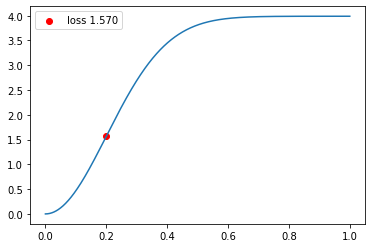

In [3]:
def normal_dist(x , mean , sd):
    prob_density = 1/(sd*np.sqrt(2*np.pi))* np.exp(-0.5*((x-mean)/(2*sd))**2)
    return prob_density

x = np.arange(0, 1, 0.001)
p = 0.2
sd = 0.1
max = 10/(np.sqrt(2*np.pi))
f = max-normal_dist(x,0,sd)
loss = max-normal_dist(p,0,sd)

plt.plot(x,f)
plt.scatter(p,loss, c='r',label="loss {:.3f}".format(loss))
plt.legend()
plt.show()

## List (and rename depth images)

In [88]:
train_path,train_name = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/img/temp", ".png")
_,test_name = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/img", ".png")

d_path, d_name = utils.list_files("/home/bbejczy/repos/GALIROOT/data/l515_imgs/", ".png")

test_out = "/home/bbejczy/repos/GALIROOT/data/l515_lab_1410_test/depth/"
train_out = "/home/bbejczy/repos/GALIROOT/data/l515_lab_1410/depth/"

# def _replace_text(list, oldtext, newtext):
#     newlist = []
#     for name in list:
#         name = name.replace(oldtext,newtext)
#         newlist.append(name)
#     return newlist

# train_d_list = _replace_text(train_name, "rgb", "depth")
# test_d_list = _replace_text(test_name, "rgb", "depth")

# tc, tec = 0,0

# for idx, name in enumerate(d_name):
#     # print(name)
#     if "depth" in name:
#         if name in test_d_list:
#             try: 
#                 shutil.copyfile(d_path[idx],test_out+f"{name}")
#                 tec += 1
#             except shutil.Error:
#                 print(f"{name} already exists")
#                 pass
#         if name in train_d_list:
#             try: 
#                 shutil.copyfile(d_path[idx],train_out+f"{name}")
#                 tc += 1
#             except shutil.Error:
#                 print(f"{name} already exists")
#                 pass

# print(f"train {tc} test {tec}")

In [89]:
train_path_d,train_name_d = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/depth/temp", ".png")
_,test_name_d = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/depth", ".png")

## Mapping from 0-1

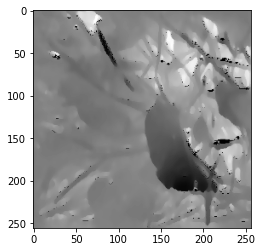

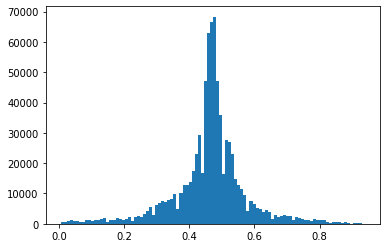

In [46]:
image_pil = np.asarray(Image.open('/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/depth/temp/20200623_skaevinge_depth_0_1624440580560785294.png'))

transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000), A.Normalize(mean = [0.7188], std = [0.1109]), A.Resize(256,256)]) #, A.Normalize(mean = [0.7188], std = [0.1109])]

img = ((image_pil-300))/((500-300)) # subtracting lower bound, dividing by "new" upper bound"
img = img.clip(min=0, max=1) # clipping extra values, as we do not use absolute upper and lower bound
transformed = transform(image =img)
plt.imshow(transformed['image'], cmap='gray')
plt.show()
plt.figure(2)
plt.hist(img[img!=0].ravel(),bins=100);

plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


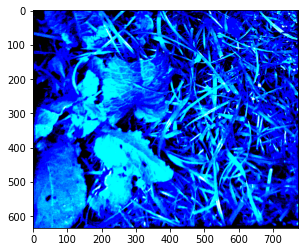

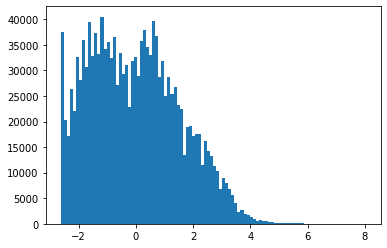

In [7]:
image = cv2.imread(train_path[50])

transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000), A.Normalize(mean=[0.3399, 0.3449, 0.1555], std=[0.1296, 0.1372, 0.1044])]) #, A.Normalize(mean = [0.7188], std = [0.1109])]

# img = ((image_pil-300)*255)/((500-300)) # subtracting lower bound, dividing by "new" upper bound"
# img = img.clip(min=0, max=255) # clipping extra values, as we do not use absolute upper and lower bound
transformed = transform(image =image)
plt.imshow(transformed['image'], cmap='gray')
plt.show()
plt.figure(2)
plt.hist(transformed['image'].ravel(),bins=100);

plt.show();

Count how many entries would fall outside of the max with the different ranges

In [8]:
transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000), A.Normalize(mean = [180.62], std = [47.2969])]) #
count=0
for path in tqdm(train_path_d):
    image_pil = np.asarray(Image.open(path))
    img = (image_pil-300)*255/((500-300))
    img = img.clip(min=0)
    transformed = transform(image =img)
    # print(transformed['image'].max())
    if transformed['image'].max()>255:
        count+=1
print(count)

100%|██████████| 111/111 [00:06<00:00, 16.97it/s]

0


In [9]:
annotations_path, __ = utils.list_files('/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/ann', '.json')
annotations_path2, __ = utils.list_files('/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/ann', '.json')
image_path, __ = utils.list_files('/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/img', '.png')
image_path2, __ = utils.list_files('/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/img', '.png')
ann_list = annotations_path+annotations_path2
img_list = image_path+image_path2
# print(len(ann_list), len(img_list))

visible_point = []
occluded_points = []
transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000)],keypoint_params=A.KeypointParams(format='xy'))
seq = tqdm(zip(ann_list,img_list))
for ann, img in seq:
    with open(ann,"r") as j:
        annotation = json.load(j)
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if annotation['tags'][0]['name'] == "visible":

        points = annotation['objects'][0]['points']['exterior'][0]
        points = [(points[0],points[1])]
        transformed = transform(image=image, keypoints=points)
        points=transformed['keypoints']
        visible_point.append(points)

    elif annotation['tags'][0]['name'] == "occluded":

        points = annotation['objects'][0]['points']['exterior'][0]
        points = [(points[0],points[1])]
        transformed = transform(image=image, keypoints=points)
        points=transformed['keypoints']
        occluded_points.append(points)


print(len(visible_point))
print(len(occluded_points))

131it [00:07, 17.65it/s]

50
81


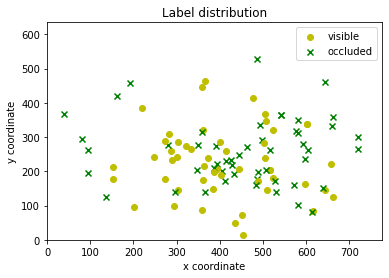

<Figure size 432x288 with 0 Axes>

In [9]:
fig = plt.subplot()
fig.title.set_text('Label distribution')
for i,j in zip(visible_point,occluded_points):
    # print("visible:",i)
    # print("occluded:",j)
    fig.scatter(i[0][0],i[0][1], marker = 'o', c = 'y')
    fig.scatter(j[0][0],j[0][1], marker = 'x', c = 'g')
    fig.set_xlim([0,775])
    fig.set_ylim([0,635])
    fig.set_xlabel('x coordinate')
    fig.set_ylabel('y coordinate')
fig.scatter(visible_point[0][0][0],visible_point[0][0][1], marker = 'o', c = 'y', label="visible")
fig.scatter(occluded_points[0][0][0],occluded_points[0][0][1], marker = 'x', c = 'g', label="occluded")
fig.legend()
plt.show()
plt.savefig('/zhome/3b/d/154066/repos/GALIROOT/label_distribution.png')

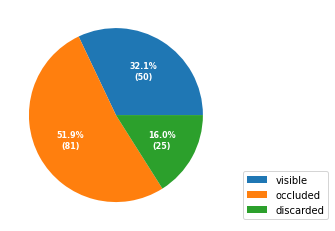

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4), subplot_kw=dict(aspect="equal"))

recipe = ["50 visible",
          "81 occluded",
          "25 discarded"]

data = [float(x.split()[0]) for x in recipe]
ingredients = [x.split()[-1] for x in recipe]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          loc=4,
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

# ax.set_title("Label categories")

plt.show()

In [27]:
from models import models_list

from torchsummary import summary

summary(models_list[5], input_size=(3, 256, 256))

pytorch_total_params = sum(p.numel() for p in models_list[7].parameters())
pytorch_total_params = sum(p.numel() for p in models_list[5].parameters() if p.requires_grad)
print(pytorch_total_params)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

# Boxplots for results

In [92]:
from models import models_list


boxplot_name_list =[]
boxplot_list = []
loss_list = []
plot_colors = ['r','y','b']
# configs_list = ['selfnet_1_2','selfnet_ch4_1','resnet18_4','resnet18_ch4_1_4']
# configs_name_list = [ 'selfnet_RGB','selfnet_RGB-D', 'resnet18_RGB', 'resnet18_RGB-D']
configs_list = ['resnet18_4_4', 'resnet18_4_3_np', 'resnet18_ch4_1_4']
configs_name_list = ['resnet18_RGB','resnet18_RGB_npt', 'resnet18_RGB-D']

In [95]:
for name, config_name in zip(configs_name_list, configs_list):

    config = utils.open_config(f'/zhome/3b/d/154066/repos/GALIROOT/config/{config_name}.json')

    folders, processing, training = utils.first_layer_keys(config)

    ann_list, __ = utils.list_files("../data/l515_lab_1410_test/ann", processing['format_ann'])
    img_list, __ = utils.list_files("../data/l515_lab_1410_test/img", processing['format_img'])
    mask_list, __ = utils.list_files("../data/l515_lab_1410_test/depth", processing['format_img'])

    train_transform, valid_transform = loader.generate_transform(config)

    dataset = loader.KeypointsDataset(config, ann_list, img_list, mask_list, valid_transform, training['depth'])
    data_load = torch.utils.data.DataLoader(dataset)

    model = models_list[training['model']]
    model.eval()
    model.load_state_dict(torch.load(os.path.join(folders['out_folder'],f"{training['checkpoint_name']}.pt"),map_location='cpu'))


    # Boxplot for distance offsets

    distance_list = []
    prediction_list = []
    ground_truth_list = []
    for data in data_load:
        image = data['image'] # BUG: throws an error when run individually (comment it out)
        keypoints = torch.mul(data['keypoints'],255)
        prediction = torch.mul(model(image), 255)
        keypoints_np = [int(x) for x in keypoints.cpu().detach().numpy()[0][0]]
        prediction_np = [int(x) for x in prediction.cpu().detach().numpy()[0]]
        distance_list.append(utils.eucledian_dist(prediction_np, keypoints_np))


    boxplot_name_list.append(name)
    boxplot_list.append(distance_list)

    print("\n",name)
    print(distance_list)
    print(f'MEAN: {np.mean(distance_list)}')
    print(f'MEDIAN: {np.median(distance_list)}\n')

Generating new transforms.
Generating augmentation json.


 resnet18_RGB
[45.0111097397076, 54.67174773134658, 59.481089431852205, 45.27692569068709, 14.866068747318506, 34.713109915419565, 64.8459713474939, 31.38470965295043, 43.86342439892262, 67.89698078707183, 73.49829930005184, 77.10382610480494, 37.20215047547655, 46.51881339845203, 59.81638571495272, 28.160255680657446, 16.97056274847714, 31.906112267087632, 25.612496949731394, 52.32590180780452]
MEAN: 45.55629709451333
MEDIAN: 45.14401771519734

Generating new transforms.
Generating augmentation json.


 resnet18_RGB_npt
[79.81227975693966, 31.38470965295043, 20.591260281974, 39.395431207184416, 29.546573405388315, 23.021728866442675, 55.47071299343465, 18.439088914585774, 50.28916384272063, 34.48187929913333, 50.695167422546305, 75.28612089887484, 54.147945482723536, 41.23105625617661, 33.54101966249684, 30.01666203960727, 19.4164878389476, 43.41658669218482, 26.076809620810597, 44.598206241955516]
MEAN: 40.04294451885389
MEDI

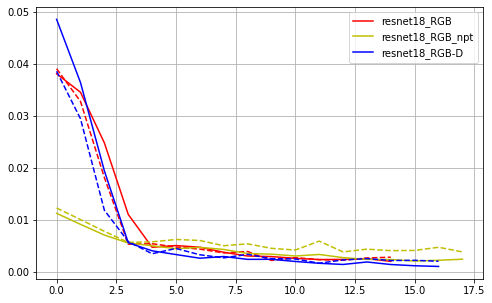

In [97]:
plt.figure(figsize=(8,5))
# plt.title("all losses etc")
plt.grid()

for name, config_name, color in zip(configs_name_list, configs_list, plot_colors):

    config = utils.open_config(f'/zhome/3b/d/154066/repos/GALIROOT/config/{config_name}.json')
    folders, processing, training = utils.first_layer_keys(config)

    loss_dictionary = utils.open_config(folders['out_folder']+f"loss_{training['checkpoint_name']}.json")

    average_fold = loss_dictionary['average']
    average_fold_train = loss_dictionary['all_losses']['fold{}'.format(average_fold)]['train_loss']
    average_fold_valid = loss_dictionary['all_losses']['fold{}'.format(average_fold)]['valid_loss']

    plt.plot(range(len(average_fold_train)), average_fold_train, c = color, label=f"{name}")
    plt.plot(range(len(average_fold_valid)), average_fold_valid, '--', c = color)

plt.legend()